<a href="https://colab.research.google.com/github/azullah/DTSA5511_Week3_kaggle/blob/main/Histopathologic_Cancer_Detection_Week3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DTSA - 5511 Deeplearning - Week 3 Kaggle Challenge
## Histopathologic Cancer Detection
### https://www.kaggle.com/c/histopathologic-cancer-detection/overview

This notebook contains the code for the Week 3 mini-project Histopathologic Cancer Detection from Kaggle.

The objective of the project is to detect Metastasis for Histopathologic Cancer, in the given dataset of input images. This will be treated as a binary classification problem,

#### From the Kaggle Project dataset description

In this dataset, you are provided with a large number of small pathology images to classify. Files are named with an image id. The train_labels.csv file provides the ground truth for the images in the train folder. You are predicting the labels for the images in the test folder. A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image.

The original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates. We have otherwise maintained the same data and splits as the PCam benchmark.

#### STEP 1 : Copy and Unzip files from Google drive
The zip data file was earlier copied from the Kaggle project to my personal google drive. How to do so using the python kaggle API [instructions can be found here](https://towardsdatascience.com/downloading-kaggle-datasets-directly-into-google-colab-c8f0f407d73a)

In [3]:
# Complete path to storage location of the .zip file of data
# Mount google drive
import os
from google.colab import drive
drive.mount('/gdrive')

zip_path = '/gdrive/MyDrive/kaggle/histopathologic-cancer-detection.zip'
# Check current directory (be sure you're in the directory where Colab operates: '/content')
print(os.getcwd())
# Copy the .zip file into the present directory
!cp '{zip_path}' .
# Unzip quietly
!unzip -q 'histopathologic-cancer-detection.zip'
# View the unzipped contents in the virtual machine
os.listdir()

Mounted at /gdrive
/content


['.config',
 'sample_submission.csv',
 'train',
 'test',
 'train_labels.csv',
 'histopathologic-cancer-detection.zip',
 'sample_data']

#### STEP 2: Import all required libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as k

## Exploratory Data Analysis

### Read the Training labels file
This is a csv file with the image ID and the label.

*Note: The image files are .tif files with the image ID as their name*

In [5]:
train = pd.read_csv('./train_labels.csv', dtype=str)
print(train.shape)

(220025, 2)


In [6]:
train.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [7]:
train.id = train.id + '.tif'

train.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


#### Check the proportion of labels in the training set

In [8]:
(train.label.value_counts() / len(train)).to_frame().sort_index().T

label,0,1
count,0.594969,0.405031


### Extract some sample images from the training set

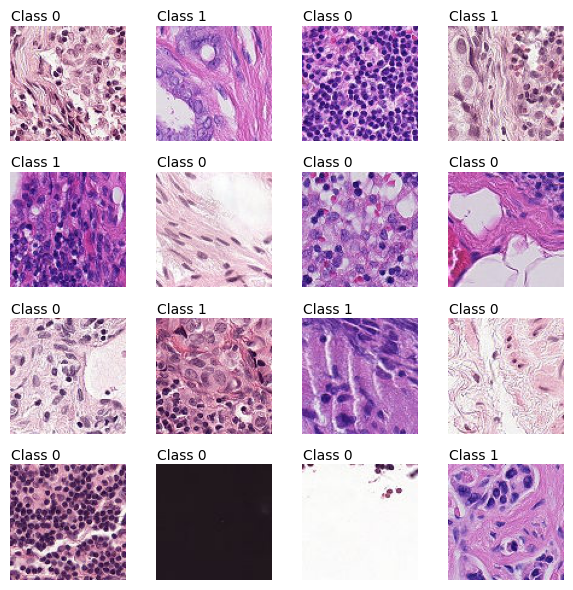

In [9]:
train_path = "./train"

sample = train.sample(n=16).reset_index()

plt.figure(figsize=(6,6))

for i, row in sample.iterrows():

    img = mpimg.imread(f'./train/{row.id}')
    label = row.label

    plt.subplot(4,4,i+1)
    plt.imshow(img)
    plt.text(0, -5, f'Class {label}', color='k')

    plt.axis('off')

plt.tight_layout()
plt.show()

### Split training set for validation

In [10]:
train_df, valid_df = train_test_split(train, test_size=0.2, random_state=1, stratify=train.label)

In [11]:
print(train_df.shape)
print(valid_df.shape)
train_df.head()

(176020, 2)
(44005, 2)


,id,label
169632,05afcb247924970d9c7c17ccf956db20f8b626f3.tif,0
48553,55e47dbf379817bf65ba25ac599a639638a44bbb.tif,0
165988,836b2171417da27f68be363c80fd53e0319f875f.tif,1
48724,8ff04d223f6ce6d707565e9cf19ca4f040e6b8d5.tif,0
173841,af80e9b4701f43eb0354dc58088186a1a76f897a.tif,1


### Generate image data using keras image library function ImageDataGenerator


In [12]:
train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)

In [13]:
BATCH_SIZE = 64

#### Load the train dataset into the ImageDataGenerator
#### Initially we choose a target size of 96,96,3 (1/2 of the original image)

train_loader = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    directory = train_path,
    x_col = 'id',
    y_col = 'label',
    batch_size = BATCH_SIZE,
    seed = 1,
    shuffle = True,
    class_mode = 'categorical',
    target_size = (96,96)
)

#### Load the valid dataset into the ImageDataGenerator

valid_loader = train_datagen.flow_from_dataframe(
    dataframe = valid_df,
    directory = train_path,
    x_col = 'id',
    y_col = 'label',
    batch_size = BATCH_SIZE,
    seed = 1,
    shuffle = True,
    class_mode = 'categorical',
    target_size = (96,96)
)


Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


In [14]:
print(len(train_loader))
print(len(valid_loader))

2751
688


In [15]:
print(valid_loader[0][0].shape)

(64, 96, 96, 3)


## Build the Sequential model and add the convolutional layers
---




In [16]:
np.random.seed(1)
tf.random.set_seed(1)
model = keras.Sequential(name='nn')
model.add(layers.Conv2D(32, 3, activation="relu", padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, kernel_size=3, strides=2, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(96, kernel_size=3, activation='relu'))
model.add(layers.BatchNormalization())
#model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(layers.Flatten())
model.add(layers.Dense(2, activation='softmax'))
model.build(input_shape=valid_loader[0][0].shape)

In [17]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "nn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (64, 96, 96, 32)          896       
                                                                 
 batch_normalization (Batch  (64, 96, 96, 32)          128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (64, 47, 47, 64)          18496     
                                                                 
 batch_normalization_1 (Bat  (64, 47, 47, 64)          256       
 chNormalization)                                                
                                                                 
 conv2d_2 (Conv2D)           (64, 45, 45, 96)          55392     
                                                                 
 batch_normalization_2 (Bat  (64, 45, 45, 96)          384      

In [19]:

history = model.fit(train_loader,steps_per_epoch=100, epochs=10, validation_data=valid_loader, validation_steps=len(valid_loader)/128)

Epoch 1/10
100/100 [==============================] - 17s 166ms/step - loss: 1.9304 - accuracy: 0.7278 - val_loss: 5.8717 - val_accuracy: 0.4141
Epoch 2/10
100/100 [==============================] - 15s 147ms/step - loss: 1.8954 - accuracy: 0.7608 - val_loss: 9.5222 - val_accuracy: 0.4427
Epoch 3/10
100/100 [==============================] - 16s 160ms/step - loss: 2.1789 - accuracy: 0.7481 - val_loss: 10.4011 - val_accuracy: 0.4193
Epoch 4/10
100/100 [==============================] - 15s 149ms/step - loss: 1.7911 - accuracy: 0.7609 - val_loss: 24.3565 - val_accuracy: 0.4089
Epoch 5/10
100/100 [==============================] - 12s 120ms/step - loss: 1.5314 - accuracy: 0.7825 - val_loss: 3.4729 - val_accuracy: 0.6562
Epoch 6/10
100/100 [==============================] - 13s 129ms/step - loss: 1.5583 - accuracy: 0.7756 - val_loss: 3.1817 - val_accuracy: 0.6771
Epoch 7/10
100/100 [==============================] - 14s 144ms/step - loss: 1.3281 - accuracy: 0.7811 - val_loss: 3.6988 - val_

In [35]:
df_samples = pd.read_csv('./sample_submission.csv')
test_data = df_samples.astype(str)
test_data = test_data.sample(1000)
test_data['id'] += '.tif'


In [36]:
test = './test'
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_data,
    directory = test,
    x_col='id',
    y_col='label',
    target_size=(96,96),
    batch_size=64,
)

Found 1000 validated image filenames belonging to 1 classes.


In [38]:
#test_results = model.predict(test_generator)
loss, acc = model.evaluate(test_generator,steps=len(test_data)/100)
print('test loss is {}'.format(loss))
print('test Accuracy is {}'.format(acc))

10/10 [==============================] - 1s 74ms/step - loss: 256.8206 - accuracy: 1.0000
test loss is 256.820556640625
test Accuracy is 1.0


### Plot the model accuracy and loss by epoch

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


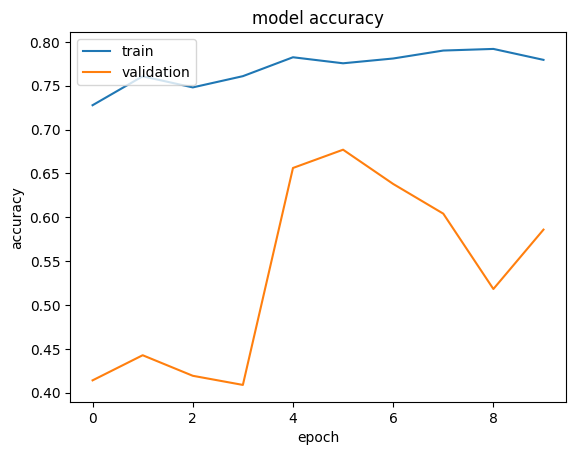

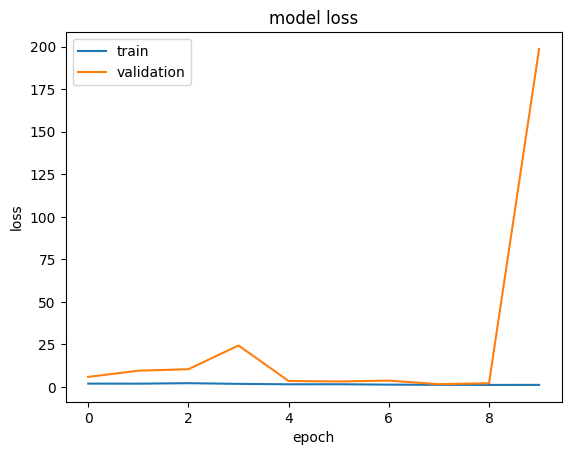

In [39]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Use model VGG19 from keras.applications


In [40]:
np.random.seed(1)
tf.random.set_seed(1)
#model2.trainable = False

base_model = keras.applications.VGG19(include_top=False, weights='imagenet', input_shape=(96,96,3))
model2 = keras.Sequential(name='model2_VGG19')
model2.add(base_model)
model2.add(layers.BatchNormalization())
model2.add(layers.Flatten())
model2.add(layers.Dense(2, activation='softmax'))
model2.build(input_shape=valid_loader[0][0].shape)
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model2.summary()


Model: "model2_VGG19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 3, 3, 512)         20024384  
                                                                 
 batch_normalization_4 (Bat  (None, 3, 3, 512)         2048      
 chNormalization)                                                
                                                                 
 flatten_2 (Flatten)         (None, 4608)              0         
                                                                 
 dense_2 (Dense)             (None, 2)                 9218      
                                                                 
Total params: 20035650 (76.43 MB)
Trainable params: 20034626 (76.43 MB)
Non-trainable params: 1024 (4.00 KB)
_________________________________________________________________


In [41]:
model2.fit(train_loader,steps_per_epoch=100, epochs=10, validation_data=valid_loader, validation_steps=len(valid_loader)/128)

Epoch 1/10
100/100 [==============================] - 28s 209ms/step - loss: 0.5649 - accuracy: 0.7077 - val_loss: 1.1833 - val_accuracy: 0.6146
Epoch 2/10
100/100 [==============================] - 21s 206ms/step - loss: 0.4445 - accuracy: 0.8008 - val_loss: 0.5305 - val_accuracy: 0.7786
Epoch 3/10
100/100 [==============================] - 20s 199ms/step - loss: 0.4208 - accuracy: 0.8125 - val_loss: 0.4341 - val_accuracy: 0.7865
Epoch 4/10
100/100 [==============================] - 20s 204ms/step - loss: 0.4016 - accuracy: 0.8250 - val_loss: 0.3661 - val_accuracy: 0.8411
Epoch 5/10
100/100 [==============================] - 21s 204ms/step - loss: 0.3450 - accuracy: 0.8558 - val_loss: 1.0672 - val_accuracy: 0.6016
Epoch 6/10
100/100 [==============================] - 21s 205ms/step - loss: 0.3315 - accuracy: 0.8620 - val_loss: 0.3191 - val_accuracy: 0.8620
Epoch 7/10
100/100 [==============================] - 20s 200ms/step - loss: 0.3289 - accuracy: 0.8634 - val_loss: 1.3612 - val_ac

In [42]:
loss2, acc2 = model2.evaluate(test_generator,steps=len(test_data)/100)
print('test loss is {}'.format(loss2))
print('test Accuracy is {}'.format(acc2))

10/10 [==============================] - 1s 77ms/step - loss: 118.1816 - accuracy: 0.8734
test loss is 118.18160247802734
test Accuracy is 0.8734375238418579
